# Частина №1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

In [4]:
train_dataset = FashionMNIST('../datasets', 
                               train=True, 
                               download=True, 
                               transform=transform)

validation_dataset = FashionMNIST('../datasets', 
                                    train=False, 
                                    transform=transform)

In [5]:
batch_size = 32

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)

validation_loader = DataLoader(dataset=validation_dataset, shuffle=False)

X_train: torch.Size([32, 1, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


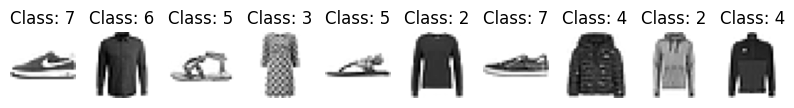

In [6]:
for (X_train, y_train) in train_loader:
    X_train = X_train.unsqueeze(1)  # Додати розмір каналу до вхідного тензора
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())

    pltsize = 1
    plt.figure(figsize=(10 * pltsize, pltsize))

    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.axis('off')
        plt.imshow(X_train[i, 0, :, :].cpu().numpy().squeeze(), cmap="gray_r")  # Відновити формат зображення
        plt.title('Class: ' + str(y_train[i].item()))

    break


In [15]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=11, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

[512, 256, 256, 128]: У цій комбінації модель має 4 шари з такою кількістю нейронів у кожному шарі: 
        перший шар - 512 нейронів, другий та третій шари - 256 нейронів, і останній шар - 128 нейронів.

In [16]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=11, bias=True)
  )
)

In [20]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [21]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [22]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.402983
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.315712
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.946121
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.794434
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.684025
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.669245
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.363226
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.346340
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.442038
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.290815

Validation set: Average loss: 0.4742, Accuracy: 8244/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.415399
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.356090
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.282598
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.476998
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.350661
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.561286
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.165601
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.268665
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.60

У результаті маємо: Average loss: 0.3386, Accuracy: 8817/10000 (88%). 

# Частина №2

Було обрано гіперпараметри для моделі:
[512, 256, 256, 128],
[256, 128],
[512, 128],
[512, 256, 128],
[512, 256, 128, 64].

Всі параметри було перевірено та знайдено найкращий, за яким точність на тестовому наборі була найвищою.
Найкращим виявився цей гіпермараметр [256, 128], його точність складає 88.81%.
[256, 128]: Ця комбінація включає 2 шари. Перший шар містить 256 нейронів, а другий шар - 128 нейронів.

In [53]:
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=11, hidden_sizes=[256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

In [54]:
model = BaseNetwork(act_fn=nn.ReLU()).to(device)

In [55]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [56]:
criterion = nn.CrossEntropyLoss()

In [58]:
model

BaseNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=11, bias=True)
  )
)

In [59]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [60]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [61]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.407280
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.828881
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.851727
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.568442
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.545413
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.454366
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.461118
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.448486
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.318904
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.536784

Validation set: Average loss: 0.4505, Accuracy: 8372/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.382083
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.526828
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.221816
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.528637
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.522753
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.195429
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.435305
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.416211
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.29

Класи на яких модель помиляється

In [62]:
def get_model_errors(model, loader):
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            
            for i in range(len(target)):
                label = target[i]
                prediction = predicted[i]
                
                if prediction != label:
                    class_correct[label] += 1
                class_total[label] += 1
    
    error_rates = [class_correct[i] / class_total[i] if class_total[i] != 0 else 0 for i in range(10)]
    
    return error_rates

Функція get_model_errors обчислює помилки для кожного класу відповідно до прогнозів моделі. Для кожного зображення у наборі даних вона порівнює прогнозований клас зі звичайним класом і збільшує class_correct, якщо прогноз не збігається зі звичайним класом label. Водночас, class_total збільшується незалежно від правильності прогнозу. У кінці, функція обчислює відношення помилок для кожного класу та повертає список error_rates, який містить ці значення.

Text(0.5, 1.0, 'Error Rates by Class')

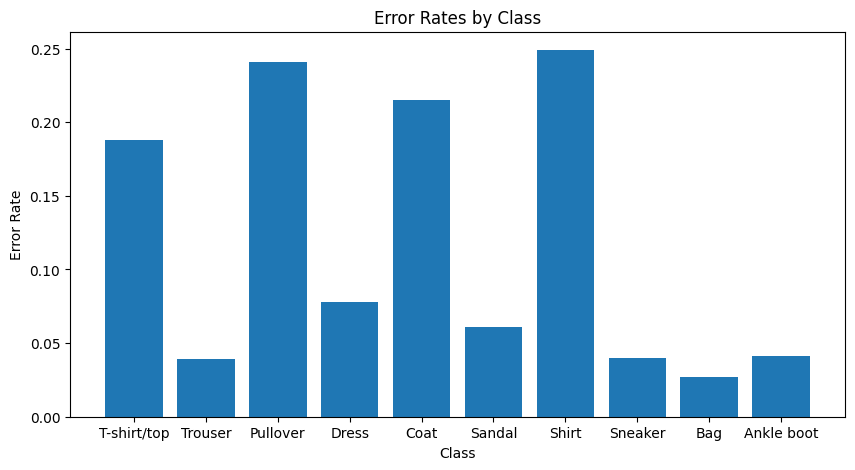

In [63]:
# Оцінка помилкових класів
error_rates = get_model_errors(model, validation_loader)

# Візуалізація помилкових класів
plt.figure(figsize=(10, 5))
plt.bar(range(10), error_rates)
plt.xticks(range(10), ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])
plt.xlabel('Class')
plt.ylabel('Error Rate')
plt.title('Error Rates by Class')

Данна частина коду візуалізує помилкові класи у вигляді стовпчикової діаграми. Кожен стовпчик представляє клас, а висота стовпчика відображає відношення помилок для цього класу. Назви класів (наприклад, 'T-shirt/top', 'Trouser' і т.д.) встановлюються за допомогою функції plt.xticks.